**Imports**

In [1]:
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *

**Load data**

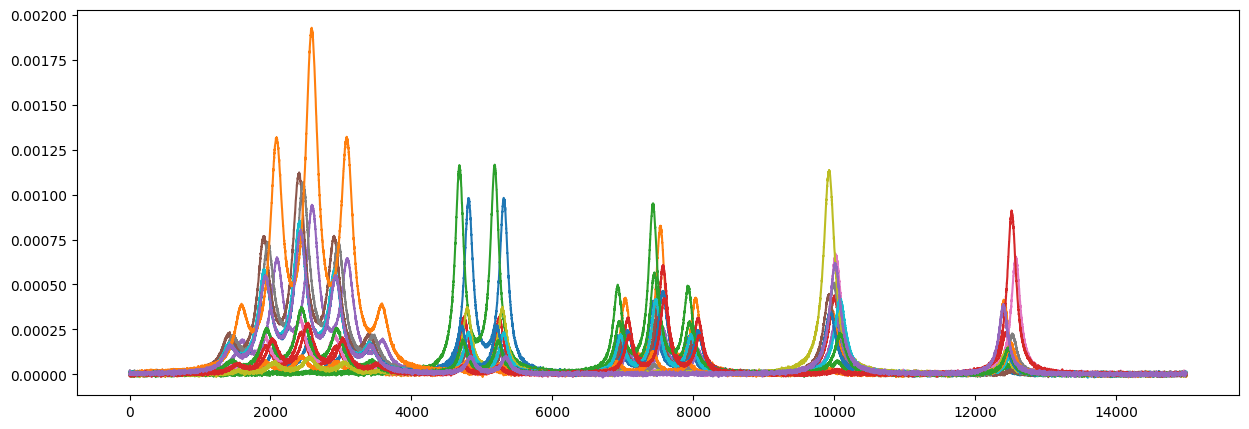

In [2]:
N, M, d = 15, 15000, 5
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V.real

np.random.seed(42)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
# W = np.append(W, [[1,0,0]], axis=0)
# W = np.append(W, [[0,1,0]], axis=0)
# W = np.append(W, [[0,0,1]], axis=0)
# N = N+3

#W = np.random.rand(N, d)
shift = 100
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
tau[W==0] = 0
#set tau to 0 where W is 0

# tau = np.zeros((N,d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
multiplets = 5
#evenly space out means
mean = np.linspace(2500, M-2500, multiplets)
# mean = [1000, 2800, 5000, 6500, 8000]
std = [np.random.randint(70, 120) for _ in range(multiplets)]
t = np.arange(0, M, 1)

H = np.array([multiplet(t, np.random.randint(1,6), m, s, 500)*(np.random.rand()+0.1) for m, s in list(zip(mean, std))])
# H_lorentz = np.array([m(m, s, t) for m, s in list(zip(mean, std))])

X = shift_dataset(W, H, tau)

noise = np.random.normal(0, 5e-6, X.shape)
# noise = np.abs(noise)
X_noisy = X + noise

plt.figure(figsize=(15, 5))
plt.plot(X_noisy.T)
plt.show()

**Fit NMF and extract components**

*TODO* Better component selection.
From jesper, further developed by me

 - Start by fitting n times for 1 component per sample with regularization (maybe bootstrap???)
 - Calculate std
 - Binary search backwards till m found with sample mean lower than (mean+2 * std) from before, where mean of m-1 is higher than (mean+2 * std)
 - That should be the estimated components

epoch: 1500, Loss: 0.013162535228470117, Tau: 3960.6740587935283


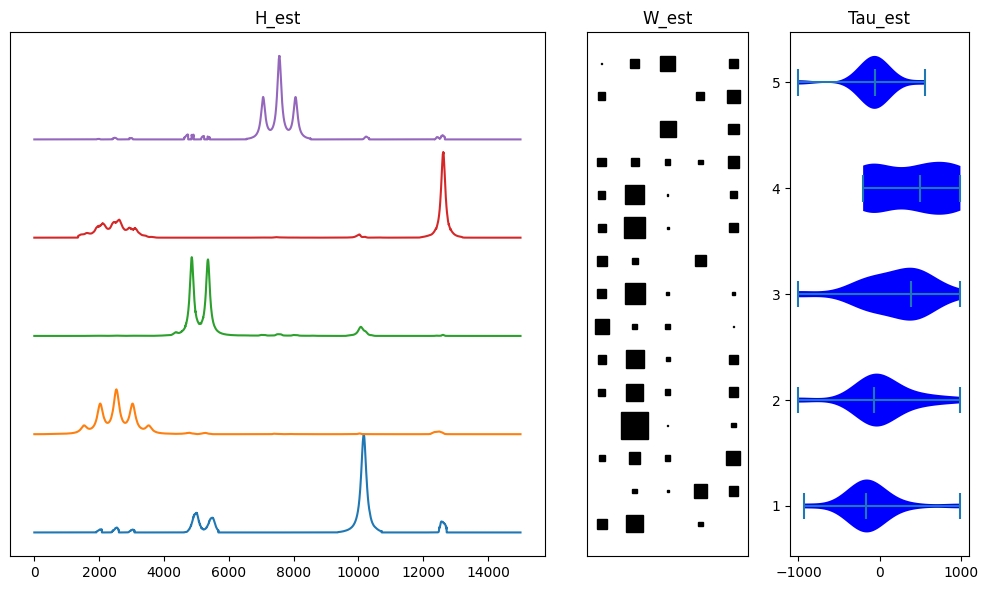

In [3]:
nmf = ShiftNMF(X, 5, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_est,H_est,tau_est, running_loss_hybrid = nmf.fit(verbose=True, return_loss=True, max_iter=1500, tau_iter=0, Lambda=0.1)


def plotSpaced(ax,x,y):
    ymax = y.max()
    yoffset = ymax
    for i in range(y.shape[1]):
        ax.plot(x,y[:,i]+yoffset*i)

    ax.set_yticks([])

def change_violin_colors(violin_parts, color_list):
    for pc, linecolor in zip(violin_parts["bodies"], color_list):
        pc.set_facecolor(linecolor)
        pc.set_alpha(1)


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'black' if w > 0 else 'white'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=False, showmedians=True, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

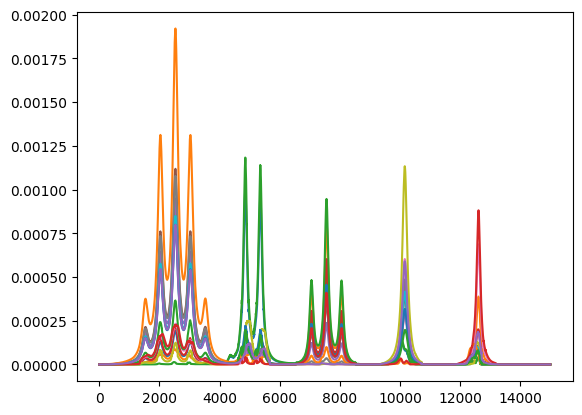

In [4]:
plt.plot(np.matmul(W_est, H_est).T)
plt.show()

**Generate hypothesis from extracted components**

In [5]:
from Hardmodel import Hard_Model
from scipy import stats
from Hardmodel_single_peaks import Single_Model
from scipy.signal import find_peaks_cwt as find_peaks
# from scipy.signal import find_peaks
import itertools

In [6]:
def single_fit(X):
    alpha = 1e-7
    #find peaks in the sample
    peaks = find_peaks(X, widths=30)
    # peaks,_  = find_peaks(X)
    print("peaks:"+str(peaks))
    model = Single_Model(X, peaks, lr=5, alpha = alpha, factor=1, patience=1, min_imp=0.001, relative_height=0.75) # min_imp=1e-3)
    W, C = model.fit(verbose=True)

    mean = model.means.detach().numpy()
    sigmas = model.sigma.detach().numpy()

    return mean, sigmas

def calc_sigma_matrix(nr_runs=10):
    mean, sigmas = single_fit(X)
    sigma_matrix = np.array([sigmas])
    for i in range(nr_runs-1):
        means, sigmas = single_fit(X)
        sigma_matrix = np.append(sigma_matrix, [sigmas], axis=0)
    return sigma_matrix
    
def calc_difference_matrix(sigmas):
    diff_matrix = np.zeros((len(sigmas),len(sigmas)))
    for i in range(len(sigmas)):
        for j in range(len(sigmas)):
            diff_matrix[i,j] = abs(sigmas[i]-sigmas[j])/sigmas[i]
    return diff_matrix

def peak_hypothesis(value_matrix, cutoff= 5/100):
    H = set()
    for i,peaks in enumerate(value_matrix):
        peaks = peaks.tolist()
        valid_peaks = set()
        for peak_index, peak in enumerate(peaks):
            if peak < cutoff:
                valid_peaks.add(peak_index)
        for combination_length in range(1,len(valid_peaks)+1):
            for h in itertools.combinations(valid_peaks, combination_length):
                H.add(tuple(sorted(h)))
    return H


means, sigmas = [], []

for i in range(len(H_est)):
    mean, sigma = single_fit(H_est[i])
    means.append(mean)
    sigmas.append(sigma)

# mean_temp,_  = single_fit(H_est[0])

peaks:[   30   140   276   395  1479  2046  2555  3045  3604  4934  5015  5445
  5512  7561 10163 12554 14970]
[1.10815038e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.29007002e-11 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.23806364e-13 0.00000000e+00 1.83354348e-10
 4.08651417e-15]
initial sigmas:
[1.44717222 1.         1.         1.         1.         1.48615366
 1.         1.         1.         1.         1.         1.
 1.         1.67998292 1.         1.65752166 1.75784618]


d:\CodingProjects\Bachelorprojekt\Hardmodel_single_peaks.py:21: PeakPropertyWarning: some peaks have a prominence of 0
  print(scipy.signal.peak_prominences(X,init_means, wlen=2000)[0])
d:\CodingProjects\Bachelorprojekt\Hardmodel_single_peaks.py:22: PeakPropertyWarning: some peaks have a prominence of 0
  sigmas = scipy.signal.peak_widths(X, init_means, wlen=1000, rel_height=relative_height)[0]/2 #.355*1.5
d:\CodingProjects\Bachelorprojekt\Hardmodel_single_peaks.py:22: PeakPropertyWarning: some peaks have a width of 0
  sigmas = scipy.signal.peak_widths(X, init_means, wlen=1000, rel_height=relative_height)[0]/2 #.355*1.5


Lorentzian %:ss: 0.036808468178131734
tensor([5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 5.0000e-01, 1.7369e-07, 9.9491e-13, 1.0000e+00,
        1.0000e+00, 5.0000e-01, 7.6481e-08, 2.1137e-12, 5.0000e-01],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([ 1.4472,  1.0000,  1.0000,  1.0000,  1.0000, -1.7122,  0.4177,  0.9997,
         1.0000, 93.3199, 82.8821, 97.0763, 63.8517,  1.6800, 88.4205, 81.7567,
         1.7578], requires_grad=True)
peaks:[   50  1532  2032  2532  3032  3533  4795  5297  6898  7398  7897  8613
  9266 10040 12333 12487 13984 14175 14321 14735 14971]
[1.11357674e-12 0.00000000e+00 0.00000000e+00 1.66586790e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.66879078e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.64586482e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
initial sigmas

Prune insignificant means with 0 sigma TODO: Move pruning into model fit to speed up fitting

In [37]:
mean_pruned = []
sigma_pruned = []
for trial in range(len(means)):
    temp_means = []
    temp_sigmas = []
    for i in range(len(means[trial])):
        if sigmas[trial][i] > 10:
            temp_means.append(means[trial][i])
            temp_sigmas.append(sigmas[trial][i])
    
    mean_pruned.append(temp_means)
    sigma_pruned.append(temp_sigmas)

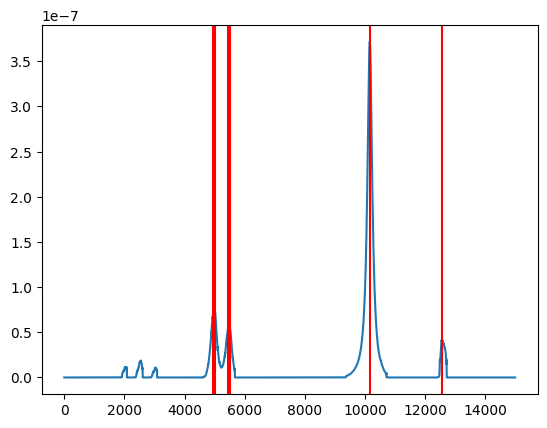

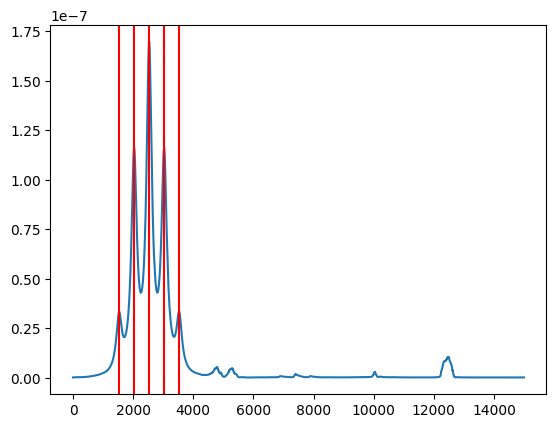

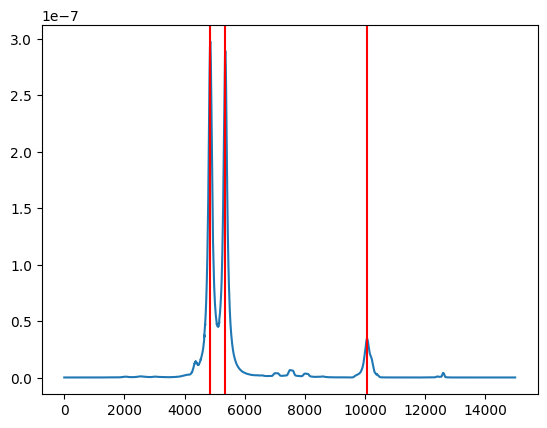

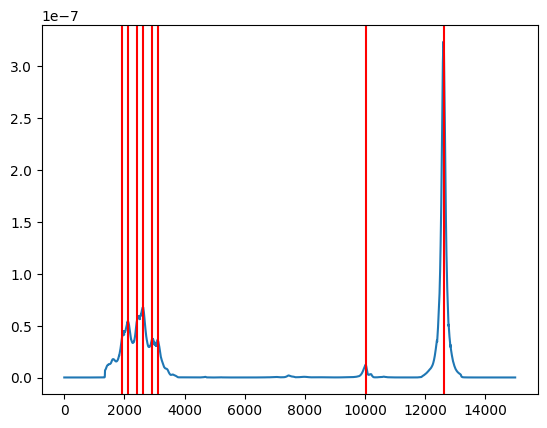

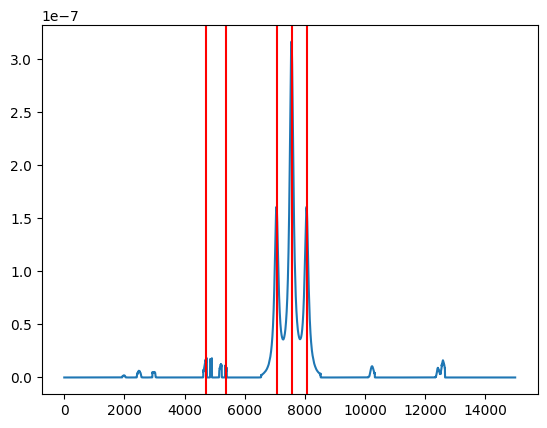

In [38]:
for i in range(len(mean_pruned)):
    plt.plot(H_est[i])
    for mean in mean_pruned[i]:
        plt.axvline(mean, color='r')
    plt.show()

In [55]:
#extract means from mean_pruned and sigmas from sigma_pruned
mean_list = []
for i in range(len(mean_pruned)):
    for j in range(len(mean_pruned[i])):
        mean_list.append(mean_pruned[i][j])

sigma_list = []
for i in range(len(sigma_pruned)):
    for j in range(len(sigma_pruned[i])):
        sigma_list.append(sigma_pruned[i][j])

initial values:
tensor([ 8203.0000,  7554.2500, 10025.0000,  6458.5000,  7621.5000,  7746.0000,
         7560.0000,  7647.3335,  6037.5000, 10070.0000,  4711.0000, 12585.5000,
         3684.5000,  7574.5000,  3820.5000,  6537.5000,  3470.6667,  1532.0000,
         2124.0000,  7691.0000,  7060.0000,  8427.6670,  4303.6665,  6146.3335,
         2532.0000,  2626.0000,  5189.5000,  8060.0000,  8816.0000,  5015.0000,
         3533.0000,  3120.0000,  8784.5000,  2532.0000,  6208.5000,  5512.0000,
         7385.6665,  5357.0000, 12617.0000,  6752.6665, 12554.0000,  7719.0000,
         1930.0000,  5376.0000,  6711.6665,  8611.5000,  2396.0000,  3836.5000,
         3988.5000,  7441.0000,  6752.5000,  2032.0000,  8792.5000,  2435.0000,
         7560.0000,  9111.5000,  7548.5000,  7480.6665,  2532.5000,  4934.0000,
         3032.0000,  2932.0000,  9265.6670,  6731.6665,  7589.0000,  6949.7500,
         5997.0000,  5445.0000,  6684.6665,  4857.0000,  3733.0000,  5924.6665,
         6497.0000,  427

ValueError: operands could not be broadcast together with shapes (15000,) (15,) 

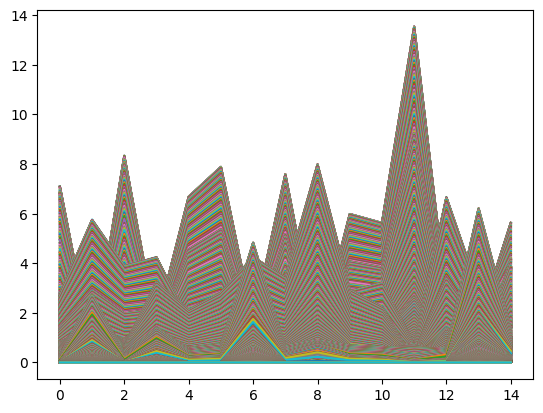

In [77]:
diff_matrix = calc_difference_matrix(sigma_list)
hypothesis = peak_hypothesis(diff_matrix)

X_aligned = np.matmul(W_est, H_est)

hardmodel = Hard_Model(X_aligned, hypothesis, mean_list, sigma_list, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
W, C = hardmodel.fit(verbose=True)

plt.plot(hardmodel.X.detach().numpy())
print("W:")
print(W)
for i, vec in enumerate(C):
    plt.plot(vec*W[:,i])
plt.title("C")
plt.show()

plt.plot(hardmodel.X.detach().numpy())
plt.plot(np.matmul(W,C).T)
plt.show()

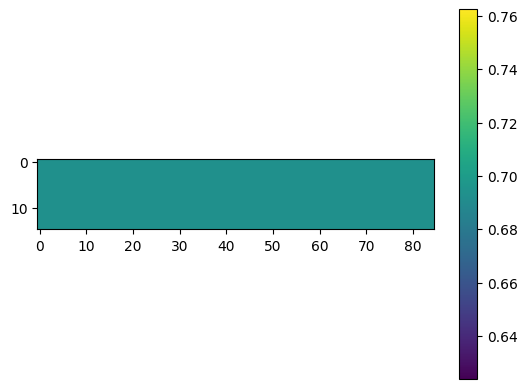

In [78]:
plt.imshow(W)
plt.colorbar()
plt.show()

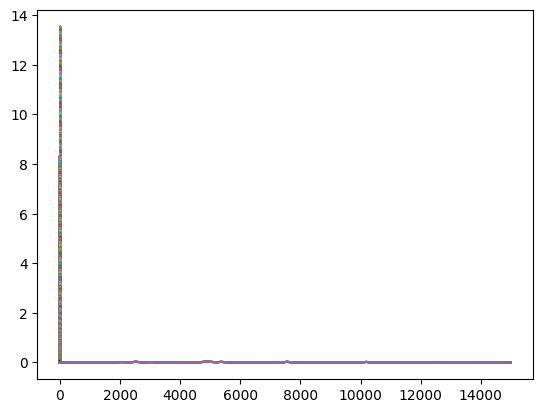

In [79]:
plt.plot(hardmodel.X.detach().numpy())
plt.plot(np.matmul(W,C).T)
plt.show()

In [76]:
import torch
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from helpers.callbacks import ChangeStopper, ImprovementStopper
from helpers.losses import frobeniusLoss, VolLoss
import scipy
import numpy as np
from nnls_l1 import nnls

class Hard_Model(torch.nn.Module):
    def __init__(self, X, H, peak_means, peak_sigmas, alpha=1e-6, lr=0.1, patience=5, factor=1, min_imp=1e-6):
        super().__init__()
        means = []
        mult = []
        sigma = []
        J_coup = []

        for hyp in H:
            means.append(np.mean([peak_means[i] for i in hyp]))
            mult.append(len(hyp))
            sigma.append(np.mean([peak_sigmas[i] for i in hyp]))
            if len(hyp) > 1:
                J_coup.append(peak_means[hyp[1]]-peak_means[hyp[0]])
            else:
                J_coup.append(1000)


        rank = len(means)
        self.X = torch.tensor(X)
        if len(X.shape) == 1:
            self.X = torch.unsqueeze(self.X,dim=0)
            n_row = 1
            n_col = X.shape[0]
            
        n_row, n_col = X.shape
        self.softplus = torch.nn.Softplus()
        self.softmax = torch.nn.Softmax()
        self.n_row = n_row # nr of samples
        self.n_col = n_col
        self.rank = rank
        
        
        self.std = torch.std(self.X)
        self.X = self.X/self.std
        
        self.lossfn = frobeniusLoss(self.X.clone().detach())
        
        # Initialization of Tensors/Matrices a and b with size NxR and RxM
        #Weights of each component
        self.W = torch.nn.Parameter(torch.rand(n_row, rank, requires_grad=True))
        self.sigma = torch.nn.Parameter(torch.tensor(sigma, requires_grad=True,dtype=torch.float32))
        self.spacing = torch.nn.Parameter(torch.tensor(J_coup, requires_grad=True,dtype=torch.float32))
        self.means = torch.tensor(means,dtype = torch.float32)
        print("initial values:")
        print(self.means)
        print(self.sigma)
        print(self.spacing)

        self.multiplicity = torch.tensor(mult,dtype=torch.int32)
        print(self.multiplicity)
        print(self.multiplicity[0])
        #self.multiplicity = torch.tensor([2,2,2])
        
        #self.H = torch.nn.Parameter(torch.randn(rank, n_col, requires_grad=True))
        #After calculation should end up with the following dimensions: rank * n_col

        # print(torch.mean(self.X, dim=0).shape

        self.optimizer = Adam(self.parameters(), lr=lr)
        
        self.stopper = ChangeStopper(alpha=alpha, patience=patience)
        self.improvement_stopper = ImprovementStopper(min_improvement=min_imp, patience=patience)
        
        # self.w_optimizer = Adam([self.W], lr=lr)
        self.peak_position_optimizer  = Adam([self.means], lr=lr)
        self.all_peak_optimizer = Adam([self.means, self.sigma, self.spacing], lr=lr)
        
        if factor < 1:
            self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=factor, patience=patience-5)
        else:
            self.scheduler = None

    def pascal(self, x):
        triangle = torch.zeros((x, x))
        for i in range(x):
            triangle[i, 0] = 1
            triangle[i, i] = 1
            if i > 0:
                for j in range(1, i):
                    triangle[i, j] = triangle[i - 1, j - 1] + triangle[i - 1, j]
        return triangle[-1]

    def lorentzian(self, x, mean, variance):
        #print(variance) nan problem was the variance
        return 1 / (torch.pi * variance * (1 + ((x - mean) / variance) ** 2))
    def gauss(self, x, mean, variance):
        return 1/(variance*(2*torch.pi)**(1/2))*torch.exp(-1/2*((x-mean)/variance)**2)

    def multiplet(self, x, mult, mean, sigma, spacing, type='lorentz'):
        triangle = self.pascal(mult)
        t_max = torch.max(triangle)
        triangle = triangle/t_max
        y = torch.zeros(len(x),dtype=float)

        if mult%2 == 0:
            space = -1*mult/2*spacing+spacing/2
        else:
            space = -1*(mult-1)/2*spacing
        for i,size in enumerate(triangle):
            if type == 'lorentz':
                y += self.lorentzian(x, mean+space, sigma)*size
            else:
                y += self.gauss(x, mean+space, sigma)*size
            space +=  spacing
        return y

    def forward(self):
        time = torch.linspace(0,self.n_col,self.n_col)
        self.C = torch.zeros((self.rank, self.n_col))
        
        for i in range(self.rank):
            self.C[i] += self.multiplet(time,
                                    self.multiplicity[i],
                                    self.means[i],
                                    torch.clamp(self.sigma[i],1),
                                    self.softplus(self.spacing[i]),
                                    type="lorentz")
        
        WC = torch.matmul(self.softplus(self.W), self.C) #self.softplus(self.C))
        return WC
    
    def fit_grad(self, grad):
        stopper = ChangeStopper(alpha=1e-3, patience=3)
        improvement_stopper = ImprovementStopper(min_improvement=1e-3, patience=3)

        while not stopper.trigger() and not improvement_stopper.trigger():
            grad.zero_grad()
            output = self.forward()
            loss = self.lossfn.forward(output)
            print(f"Loss: {loss.item()}", end='\r')
            loss.backward()
            grad.step()
            stopper.track_loss(loss)
            improvement_stopper.track_loss(loss)
        print(f"Loss: {loss.item()}")

    def fit(self, verbose=False, return_loss=False):
        running_loss = []
        iters = 0

        while not self.stopper.trigger() and not self.improvement_stopper.trigger():
            if (self.improvement_stopper.trigger()):
                print(self.improvement_stopper.trigger())
            # self.fit_grad(self.w_optimizer)
            
            iters +=1
            #fit W by nnls
            if iters > 1:
                print('\n fitting W \n')
                #copy W to numpy
                W_pre = self.W.detach().numpy()
                W_new = torch.zeros(W_pre.shape)
                
                for i in range(self.n_row):
                    C_T = self.C.T.detach().numpy()
                    X_i = self.X[i].detach().numpy()
                    
                    W = nnls(C_T, X_i[i], alpha=0.1, x0 = W_pre[i])
                    
                    W_new[i] = torch.tensor(W)
                
                self.W = torch.nn.Parameter(W_new)
            
            self.fit_grad(self.optimizer)
            # # forward
            output = self.forward()

            #loss calc
            loss = self.lossfn.forward(output)
            loss.backward()
            # # Update
            #self.optimizer.step()
    
            if self.scheduler != None:
                self.scheduler.step(loss)

            running_loss.append(loss.item())
            self.stopper.track_loss(loss)
            self.improvement_stopper.track_loss(loss)

            # print loss
            if verbose:
                print(f"epoch: {len(running_loss)}, Loss: {loss.item()}")
                # print(f"epoch: {len(running_loss)}, Loss: {loss.item()}", end='\r')

        W = self.softplus(self.W).detach().numpy()
        C = self.C.detach().numpy()
        print(self.means)
        print(self.softplus(self.sigma))
        print(self.multiplicity)
        print(self.softplus(self.spacing))
        if return_loss:
            return W, C, running_loss
        else:
            return W, C
